This notebook is used to run JAX-CANOAK in US-Hn1 site.

# Load the necessary libraries

In [1]:
# TODO: A more generic way is needed here to load the path
import sys

sys.path.append(
    "/Users/jian449/Library/CloudStorage/OneDrive-PNNL/Codes/jax-watershed/src"
    # "/global/homes/p/peishi89/jax-watershed/src"
)

In [2]:
import optax
import equinox as eqx

from functools import partial

from math import floor

# import numpy as np
import jax
import jax.numpy as jnp
import jax.tree_util as jtu

import pandas as pd

from jax_canoak.physics.energy_fluxes import get_dispersion_matrix
from jax_canoak.models import CanoakRsoilHybridIFT
from jax_canoak.models import get_soilresp, update_soilresp

# from jax_canoak.shared_utilities.optim import perform_optimization
from jax_canoak.shared_utilities.optim import perform_optimization_batch
from jax_canoak.subjects import convert_met_to_batched_met
from jax_canoak.subjects import (
    # convert_batchedstates_to_states,
    convert_obs_to_batched_obs,
)
from jax_canoak.subjects import get_met_forcings, initialize_parameters, Obs
from jax_canoak.models import run_canoak_in_batch

# from jax_canoak.models import run_canoak_in_batch_any

import matplotlib.pyplot as plt
from jax_canoak.shared_utilities.plot import (
    plot_daily,
    plot_imshow2,
    plot_timeseries_obs_1to1,
    plot_rad,
    plot_ir,
    # visualize_tree_diff,
)
from jax_canoak.shared_utilities.plot import (
    plot_obs_1to1,
    plot_obs_comparison,
    plot_obs_energy_closure,
    plot_dij,
    plot_para_sensitivity_ranking,
    plot_le_gs_lai,
    get_time,
)

# from jax_canoak.shared_utilities.plot import plot_veg_temp, plot_dij
# from jax_canoak.shared_utilities.plot import plot_ir, plot_rad, plot_prof2
from jax_canoak.shared_utilities import tune_jax_naninfs_for_debug

jax.config.update("jax_enable_x64", True)
tune_jax_naninfs_for_debug(True)
# jax.config.update("jax_debug_nans", False)
# jax.config.update("jax_debug_infs", False)
# jax.config.update("XLA_PYTHON_CLIENT_ALLOCATOR", 'platform')

%load_ext autoreload
%autoreload 2

# Model parameters and settings

In [3]:
time_zone = -8
latitude = 38.0991538
longitude = -121.49933
stomata = 1
veg_ht = 0.8
leafangle = 1
n_can_layers = 50
n_atmos_layers = 50
meas_ht = 5.0
soil_depth = 0.15
n_hr_per_day = 48
niter = 15
# niter = 1

batch_size = 1
# batch_size = 1274
# batch_size = 40290
# f_forcing = "../data/fluxtower/US-Bi1/US-Bi1-forcings-short.csv"
f_forcing = "../data/fluxtower/US-Bi1/US-Bi1-forcings.csv"

# Load and set the model forcings

In [4]:
met, n_time = get_met_forcings(f_forcing)
n_batch = floor(n_time / batch_size)
batched_met = convert_met_to_batched_met(met, n_batch, batch_size)

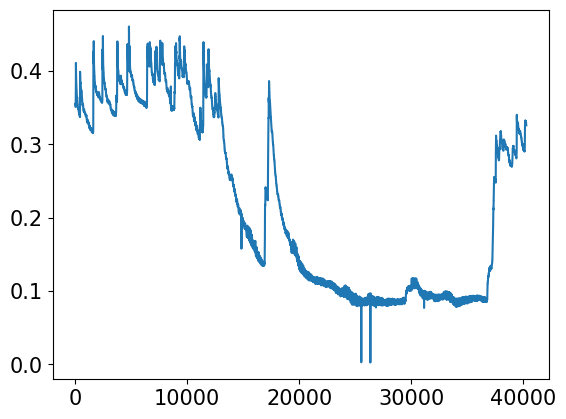

In [5]:
# plt.plot(met.eair_Pa)
# plt.plot(met.es)
# plt.plot(met.lai)
# plt.plot(veg_new.gs)
# plt.plot(met.Tsoil)
plt.plot(met.soilmoisture)

# Load the observations

In [6]:
# Read the observations
# f_obs = "../data/fluxtower/US-Bi1/US-Bi1-fluxes-short.csv"
f_obs = "../data/fluxtower/US-Bi1/US-Bi1-fluxes.csv"
obs = pd.read_csv(f_obs)
obs.interpolate(method="linear", limit_direction="both", inplace=True)
# obs[obs == -9999] = np.nan
# obs = jnp.array(obs)

P_obs = jnp.array(obs["P_F"])
LE_obs, H_obs = jnp.array(obs["LE_F_MDS"]), jnp.array(obs["H_F_MDS"])
# LE_obs, H_obs = jnp.array(obs["LE_MODIS"]), jnp.array(obs["H"])
Gsoil_obs, Rnet_obs = jnp.array(obs["G_F_MDS"]), jnp.array(obs["NETRAD"])
Rsoil_obs = jnp.array(obs["Rsoil"])

nan = jnp.nan * jnp.ones(LE_obs.size)
GPP_obs, albedo_obs, Fco2_obs = nan, nan, nan

obs = Obs(
    P_obs, LE_obs, H_obs, GPP_obs, Rnet_obs, albedo_obs, Fco2_obs, Gsoil_obs, Rsoil_obs
)
batched_obs = convert_obs_to_batched_obs(obs, n_batch, batch_size)

/var/folders/b7/q6wyxw8x1_s5rh1mqvfb8vsr0000gn/T/ipykernel_38589/3210963338.py:5: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  obs.interpolate(method="linear", limit_direction="both", inplace=True)


# Create the model parameter instance

In [7]:
setup, para = initialize_parameters(
    time_zone=time_zone,
    latitude=latitude,
    longitude=longitude,
    stomata=stomata,
    veg_ht=veg_ht,
    leafangle=leafangle,
    n_can_layers=n_can_layers,
    n_atmos_layers=n_atmos_layers,
    meas_ht=meas_ht,
    soil_depth=soil_depth,
    n_hr_per_day=n_hr_per_day,
    n_time=n_time,
    npart=int(1e6),
    niter=niter,
    met=met,
    obs=obs,
)

# Generate or read the dispersion matrix

In [8]:
# dij = get_dispersion_matrix(setup, para)
dij = get_dispersion_matrix(setup, para, "../data/dij/Dij_US-Hn1.csv")
# np.savetxt("../data/dij/Dij_US-Hn1.csv", np.array(dij), delimiter=',')

<Axes: xlabel='Dij [s/m]', ylabel='Height [m]'>

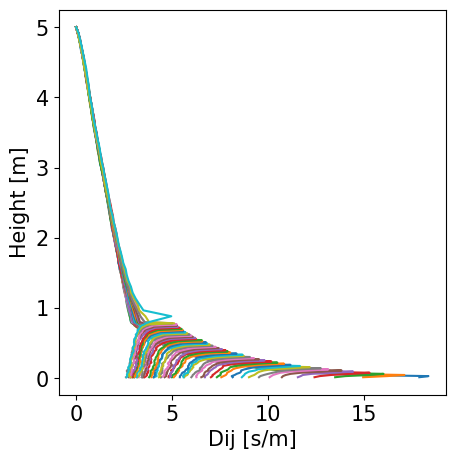

In [9]:
plot_dij(dij, para)

# Run CANOAK!

In [10]:
jax.clear_caches()
canoak_eqx_ift = CanoakRsoilHybridIFT(para, setup, dij)
# met, prof, ir, qin, sun, shade, soil, veg, can = canoak_eqx_ift(met)
states, drivers = canoak_eqx_ift(met)
met, prof, ir, qin, sun, shade, soil, veg, can = states
quantum, nir, rnet, sun_ang, leaf_ang, lai = drivers
# met, prof, ir, qin, sun, shade, soil, veg, can = run_canoak_in_batch(batched_met, canoak_eqx_ift)

In [11]:
canoak_eqx_ift.para.RsoilDL

MLP(
  layers=(
    Linear(
      weight=f64[6,2],
      bias=f64[6],
      in_features=2,
      out_features=6,
      use_bias=True
    ),
    Linear(
      weight=f64[6,6],
      bias=f64[6],
      in_features=6,
      out_features=6,
      use_bias=True
    ),
    Linear(
      weight=f64[1,6],
      bias=f64[1],
      in_features=6,
      out_features=1,
      use_bias=True
    )
  )
)

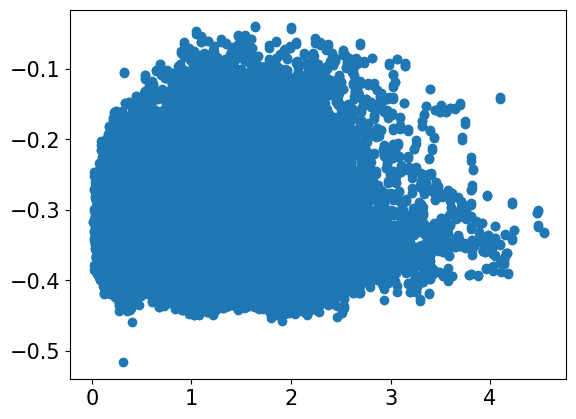

In [12]:
plt.scatter(obs.Rsoil, soil.resp)
# plt.scatter(obs.Rsoil)

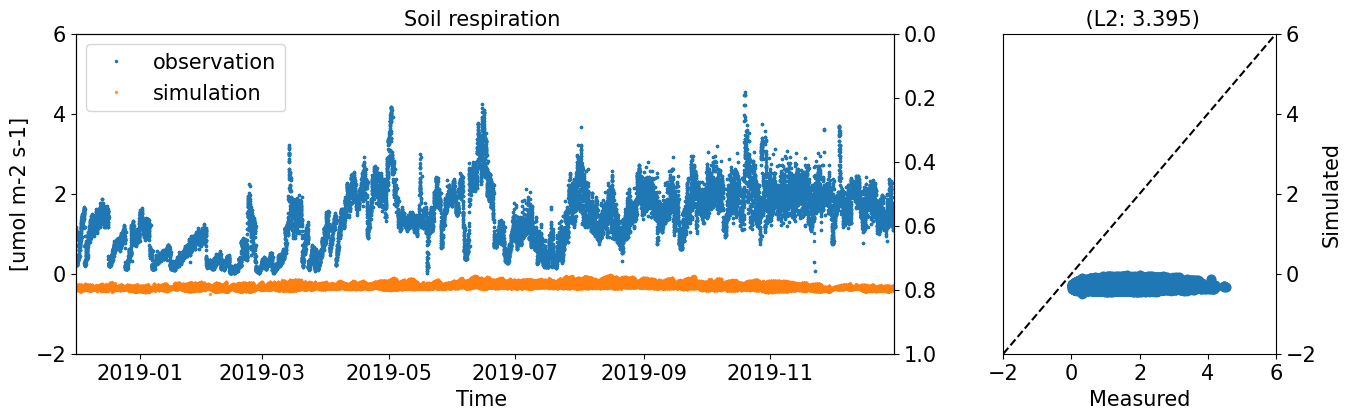

In [13]:
timesteps = get_time(met)

fig, ax1, ax2 = plot_timeseries_obs_1to1(
    obs.Rsoil,
    soil.resp,
    lim=[-2, 6],
    met=met,
    varn="Soil respiration ",
    linestyle=".",
)
ax1.set(ylabel="[umol m-2 s-1]")
ax12 = ax1.twinx()
ax12.invert_yaxis()
# ax12.plot(timesteps, met.soilmoisture, "k")
# ax12.plot(timesteps, soil.sfc_temperature, "k")
# ax12.plot(timesteps, obs.P, "k")
# ax12.plot(timesteps, obs.P, "k")
# ax12.set(ylim=[10, 0], ylabel="Rainfall [mm]")

In [14]:
# Analyze nan
nanind = jnp.where(jnp.isnan(prof.Tair_K.mean(axis=1)))

met.lai[nanind]
# qin.sun_abs[nanind]
# ir.ir_in[nanind]
sun.Tsfc[nanind, :]

Array([], dtype=float64)

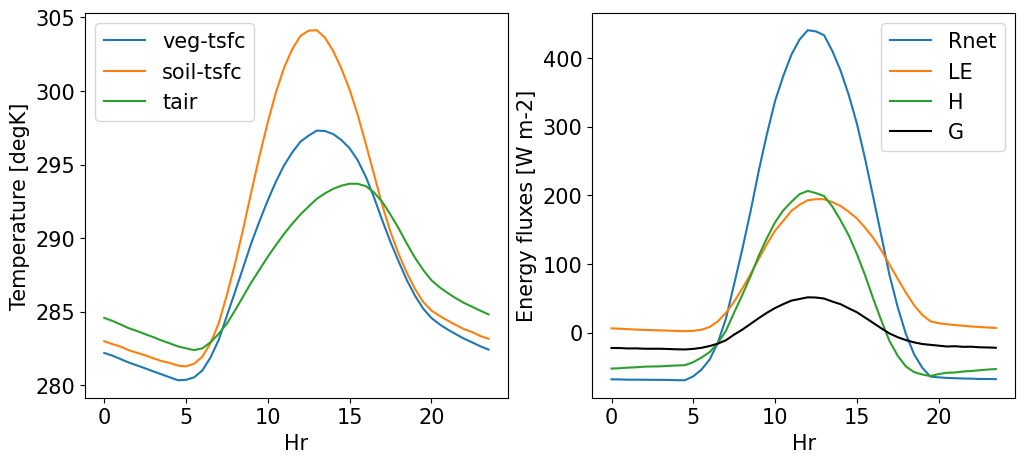

In [15]:
# Daily average
plot_daily(met, soil, veg, para);

<Axes: title={'center': 'IR flux density, W m-2'}, xlabel='Radiation Flux Density', ylabel='Canopy Cumulative LAI'>

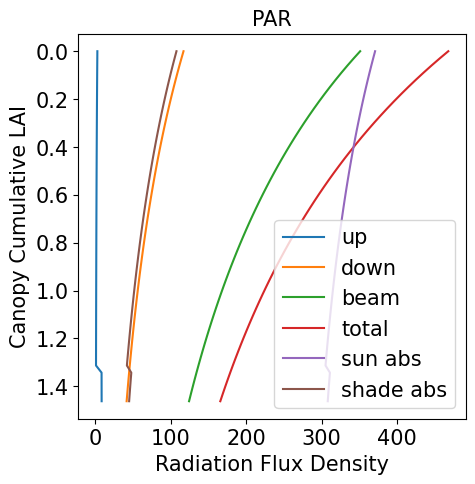

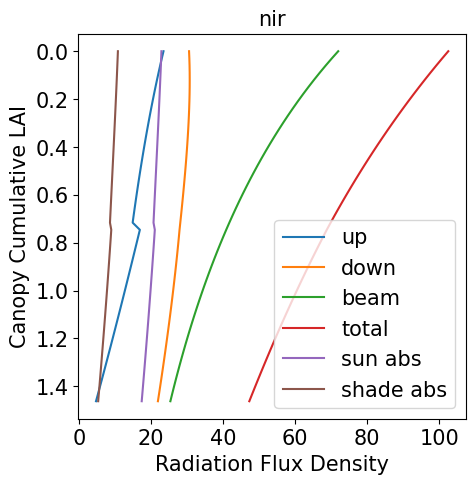

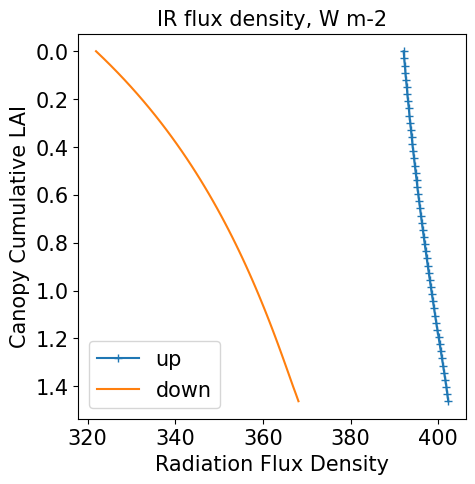

In [16]:
plot_rad(quantum, setup, lai, "PAR")
plot_rad(nir, setup, lai, "nir")
plot_ir(ir, setup, lai)

/Users/jian449/Library/CloudStorage/OneDrive-PNNL/Codes/jax-watershed/src/jax_canoak/shared_utilities/plot.py:115: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15, ha="right")
/Users/jian449/Library/CloudStorage/OneDrive-PNNL/Codes/jax-watershed/src/jax_canoak/shared_utilities/plot.py:115: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15, ha="right")
/Users/jian449/Library/CloudStorage/OneDrive-PNNL/Codes/jax-watershed/src/jax_canoak/shared_utilities/plot.py:115: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15, ha="right")


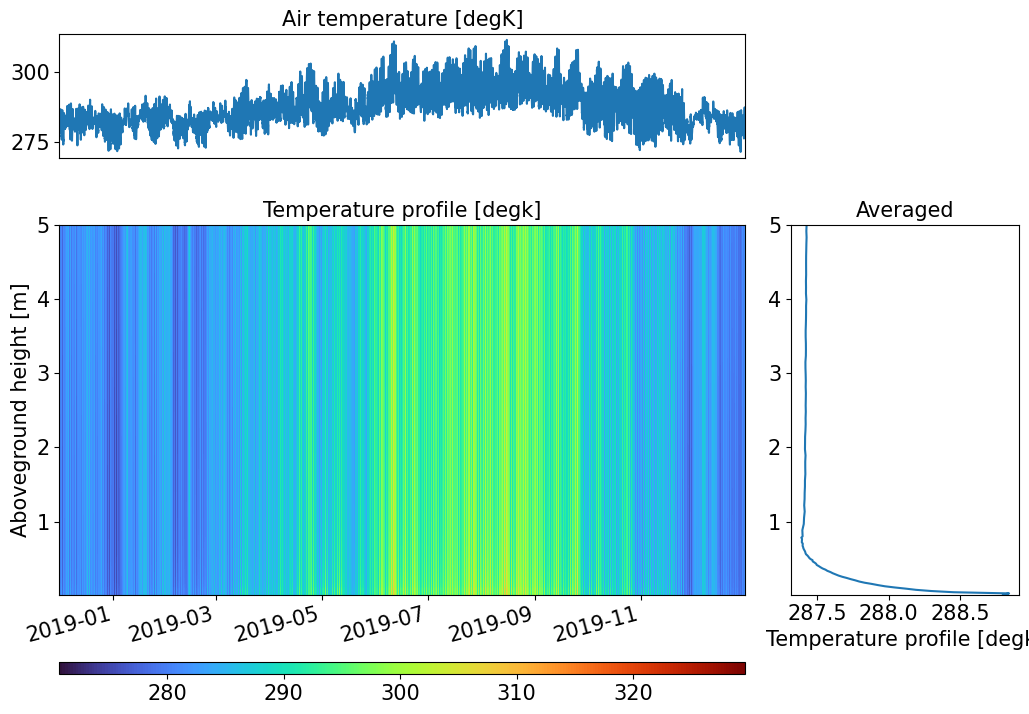

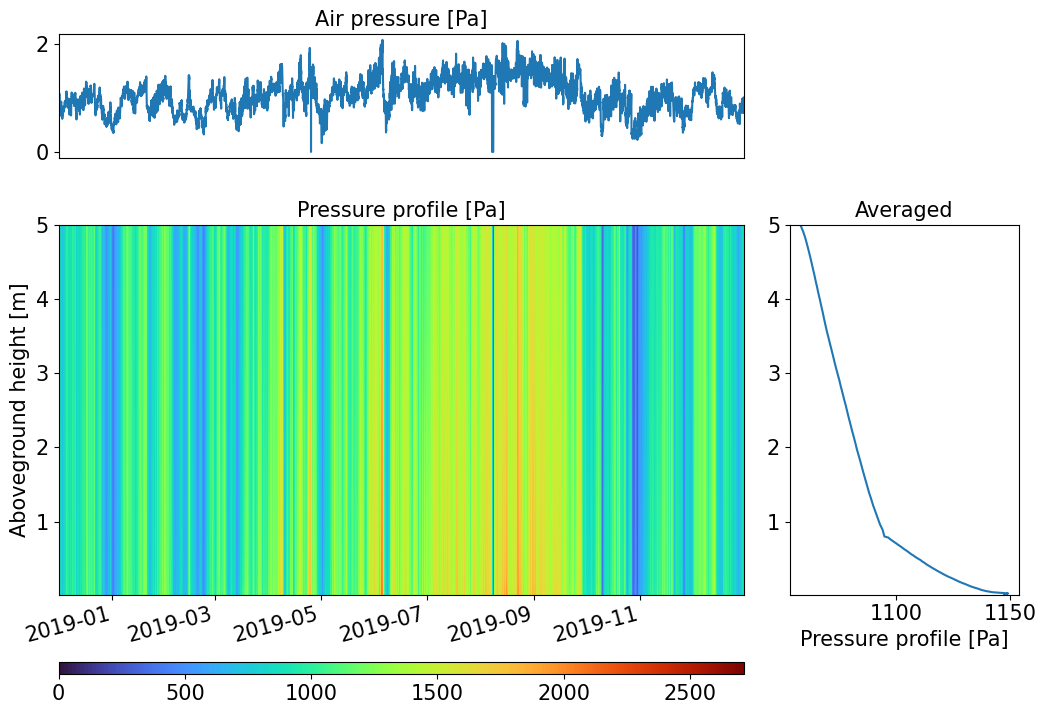

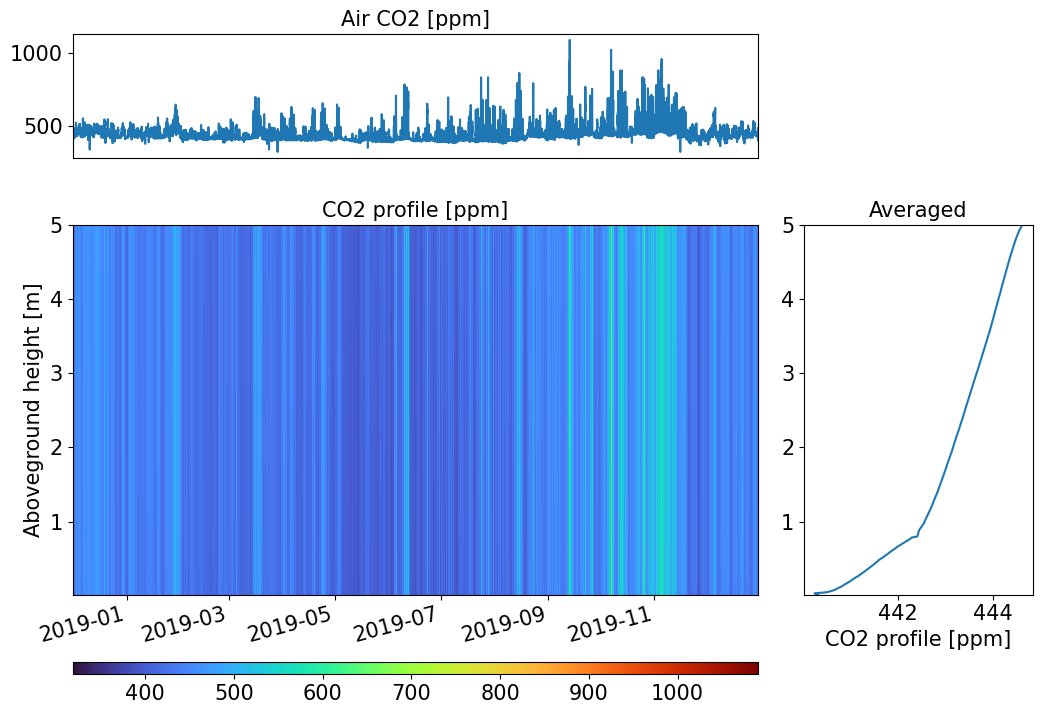

In [17]:
# Profiles
plot_imshow2(
    prof.Tair_K.T,
    met,
    para.zht,
    key="T",
    title="Temperature profile [degk]",
    cmap="turbo",
)
plot_imshow2(
    prof.eair_Pa.T, met, para.zht, key="e", title="Pressure profile [Pa]", cmap="turbo"
)
plot_imshow2(
    prof.co2.T, met, para.zht, key="co2", title="CO2 profile [ppm]", cmap="turbo"
)

/Users/jian449/Library/CloudStorage/OneDrive-PNNL/Codes/jax-watershed/src/jax_canoak/shared_utilities/plot.py:115: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15, ha="right")
/Users/jian449/Library/CloudStorage/OneDrive-PNNL/Codes/jax-watershed/src/jax_canoak/shared_utilities/plot.py:115: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15, ha="right")
/Users/jian449/Library/CloudStorage/OneDrive-PNNL/Codes/jax-watershed/src/jax_canoak/shared_utilities/plot.py:115: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15, ha="right")


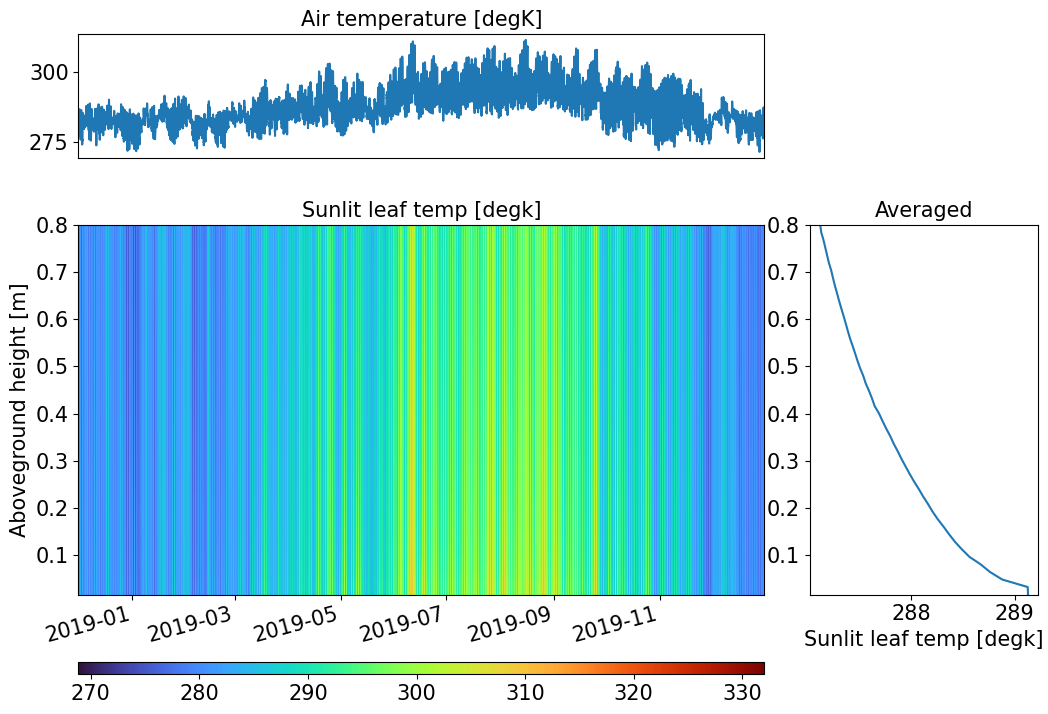

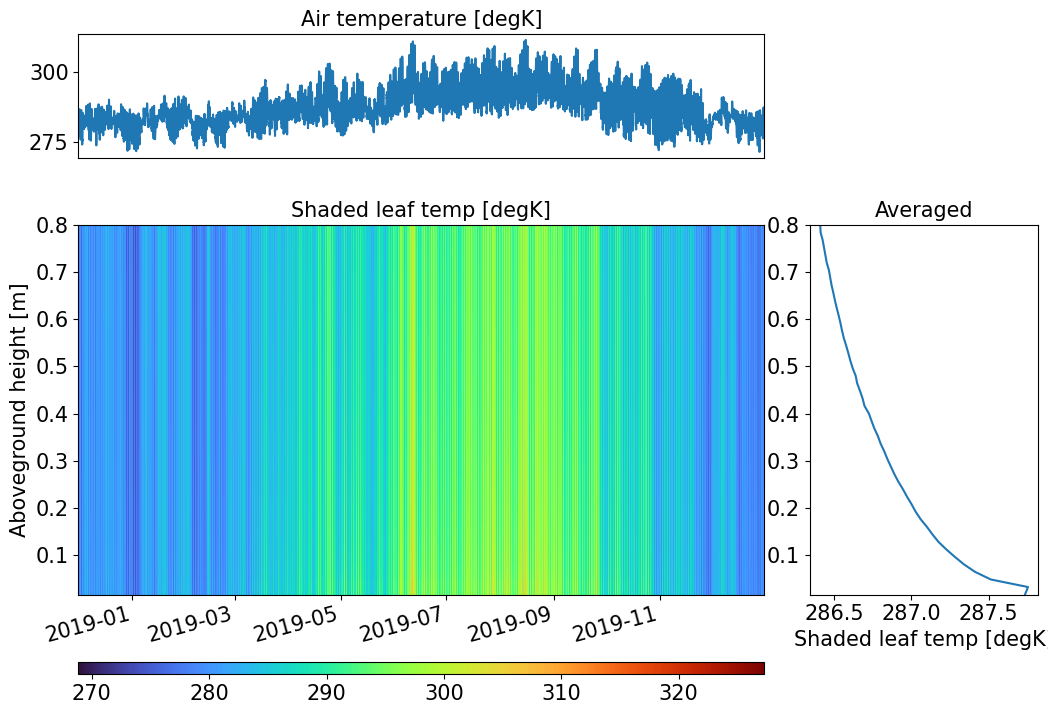

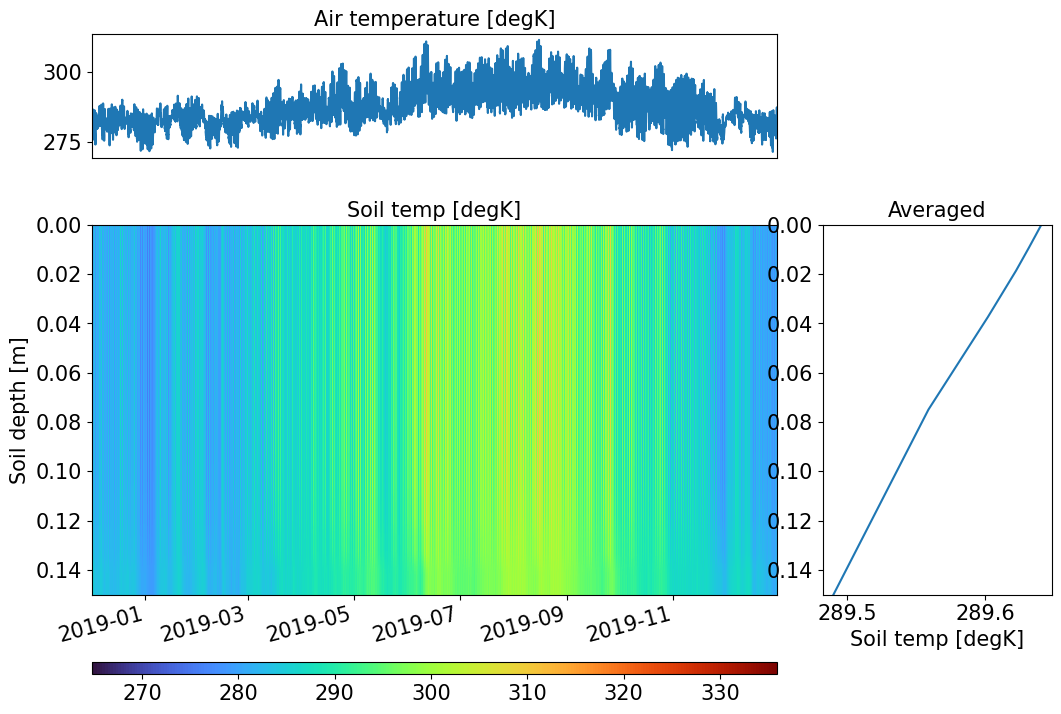

In [18]:
# Temperature
plot_imshow2(
    sun.Tsfc.T, met, para.zht1, key="T", title="Sunlit leaf temp [degk]", cmap="turbo"
)
plot_imshow2(
    shade.Tsfc.T, met, para.zht1, key="T", title="Shaded leaf temp [degK]", cmap="turbo"
)
plot_imshow2(
    soil.T_soil[:, :-1].T,
    met,
    soil.z_soil,
    key="T",
    title="Soil temp [degK]",
    cmap="turbo",
    is_canopy=False,
)

/Users/jian449/Library/CloudStorage/OneDrive-PNNL/Codes/jax-watershed/src/jax_canoak/shared_utilities/plot.py:115: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15, ha="right")
/Users/jian449/Library/CloudStorage/OneDrive-PNNL/Codes/jax-watershed/src/jax_canoak/shared_utilities/plot.py:115: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15, ha="right")
/Users/jian449/Library/CloudStorage/OneDrive-PNNL/Codes/jax-watershed/src/jax_canoak/shared_utilities/plot.py:115: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15, ha="right")
/Users/jian449/Library/CloudStorage/OneDrive-PNNL/Codes/jax-w

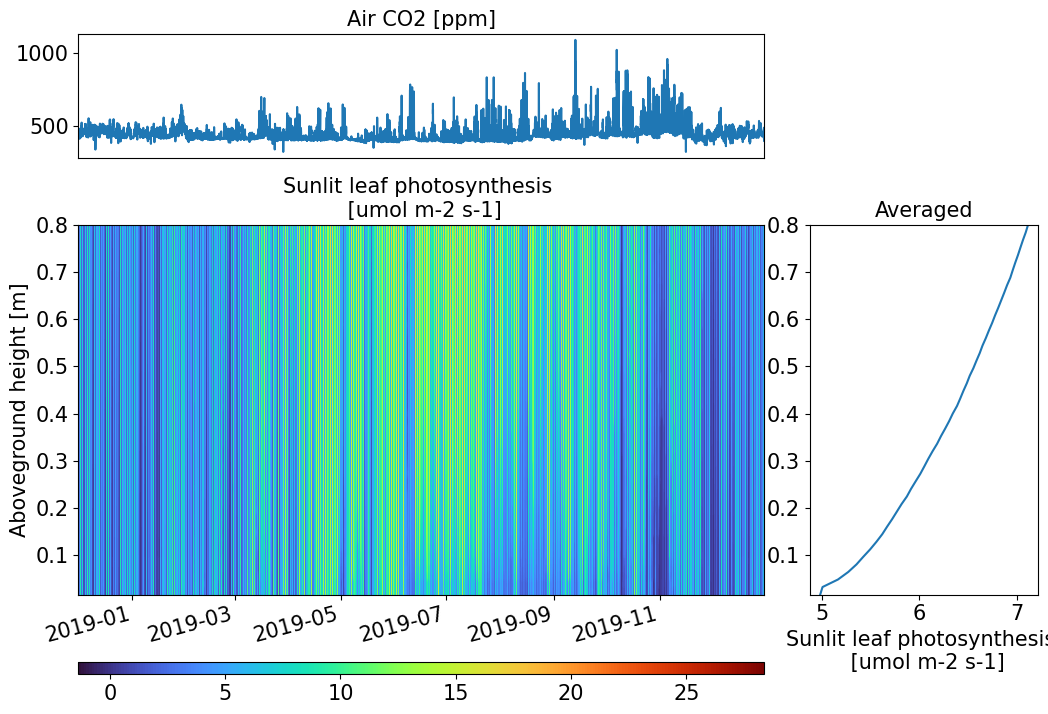

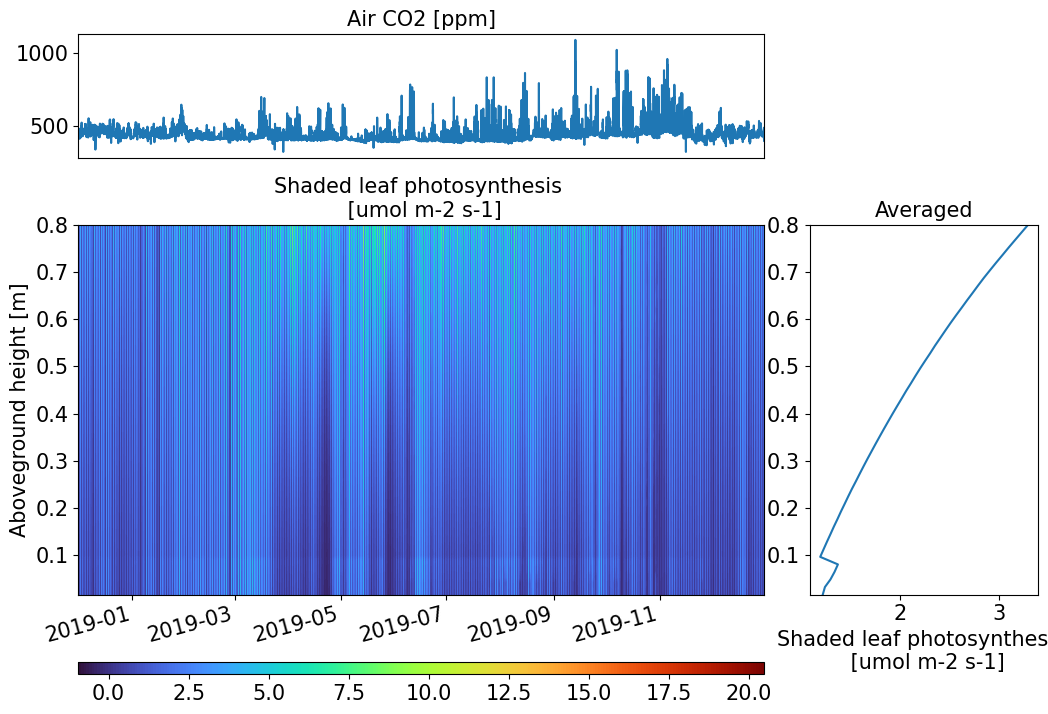

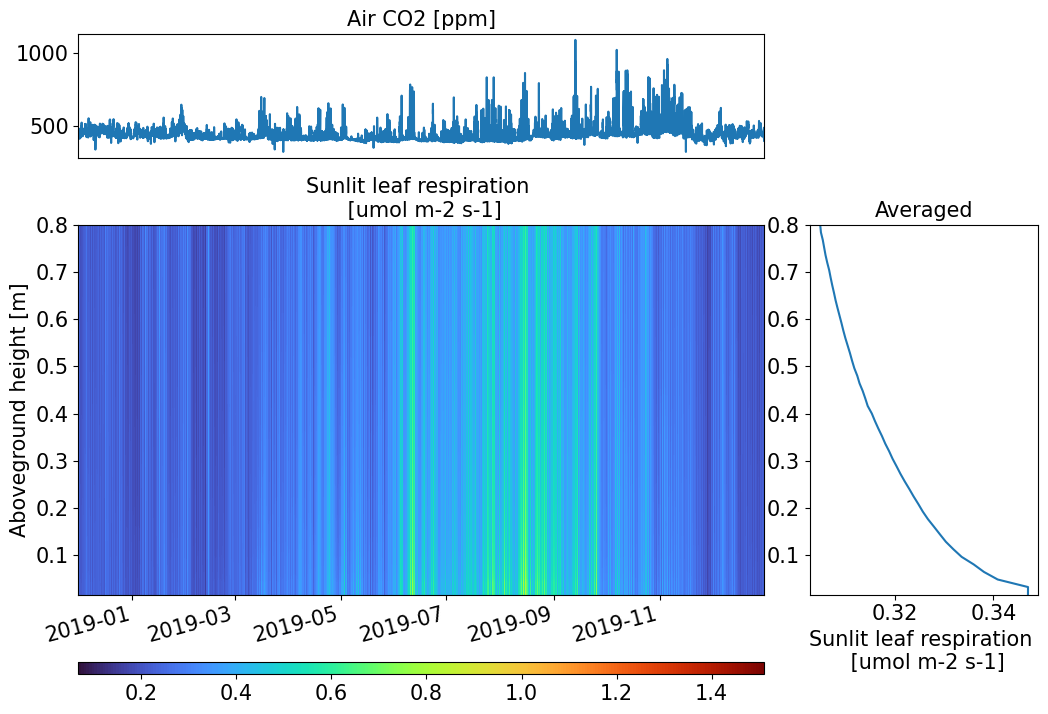

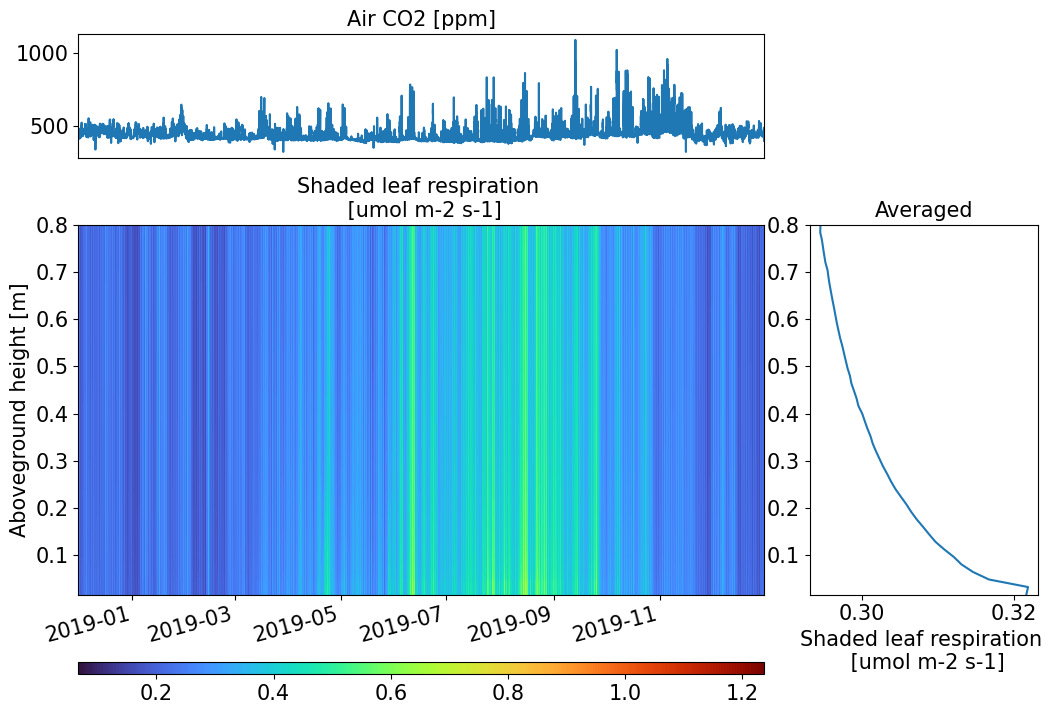

In [19]:
# respiration/photosynthesis
plot_imshow2(
    sun.Ps.T,
    met,
    para.zht1,
    key="co2",
    title="Sunlit leaf photosynthesis \n [umol m-2 s-1]",
    cmap="turbo",
)
plot_imshow2(
    shade.Ps.T,
    met,
    para.zht1,
    key="co2",
    title="Shaded leaf photosynthesis \n [umol m-2 s-1]",
    cmap="turbo",
)
plot_imshow2(
    sun.Resp.T,
    met,
    para.zht1,
    key="co2",
    title="Sunlit leaf respiration \n [umol m-2 s-1]",
    cmap="turbo",
)
plot_imshow2(
    shade.Resp.T,
    met,
    para.zht1,
    key="co2",
    title="Shaded leaf respiration \n [umol m-2 s-1]",
    cmap="turbo",
)

In [20]:
# met2 = jax.tree_util.tree_map(lambda x: x.reshape(1,816), met)
# jax.vmap(canoak, in_axes=[None,None,0,None,None,None])(para, setup, met2,
#    dij, setup.soil_mtime, setup.niter)

# Local sensitivity analysis

In [20]:
jax.clear_caches()


@eqx.filter_jit
@partial(jax.grad, argnums=0)
def df_canoak_soilresp(para, met, canoak_eqx):
    canoak_eqx = eqx.tree_at(lambda t: t.para, canoak_eqx, para)
    soilresp = canoak_eqx.get_fixed_point_states(met, update_soilresp, get_soilresp)
    return soilresp.sum()


@eqx.filter_jit
def df_canoak_soilresp_batched(para, batched_met, canoak_eqx):
    def compute_grad(para, met):
        grad = df_canoak_soilresp(para, met, canoak_eqx)
        return para, grad

    _, gradients = jax.lax.scan(compute_grad, para, xs=batched_met)
    return gradients


# eqx.filter_make_jaxpr(df_canoak_le3)(para, met, canoak_eqx)

## Perform SA at one time step

In [21]:
# canoak_eqx_ift(met2, update_soilresp, get_soilresp)

In [22]:
start, ntime = 20, 1
met2 = jtu.tree_map(lambda x: x[start : start + ntime], met)

In [23]:
gradients = df_canoak_soilresp(para, met2, canoak_eqx_ift)

In [24]:
gradients.lleaf

Array(0., dtype=float64, weak_type=True)

## Perform SA at multiple steps

In [25]:
jax.clear_caches()
gradients = df_canoak_soilresp_batched(para, batched_met, canoak_eqx_ift)

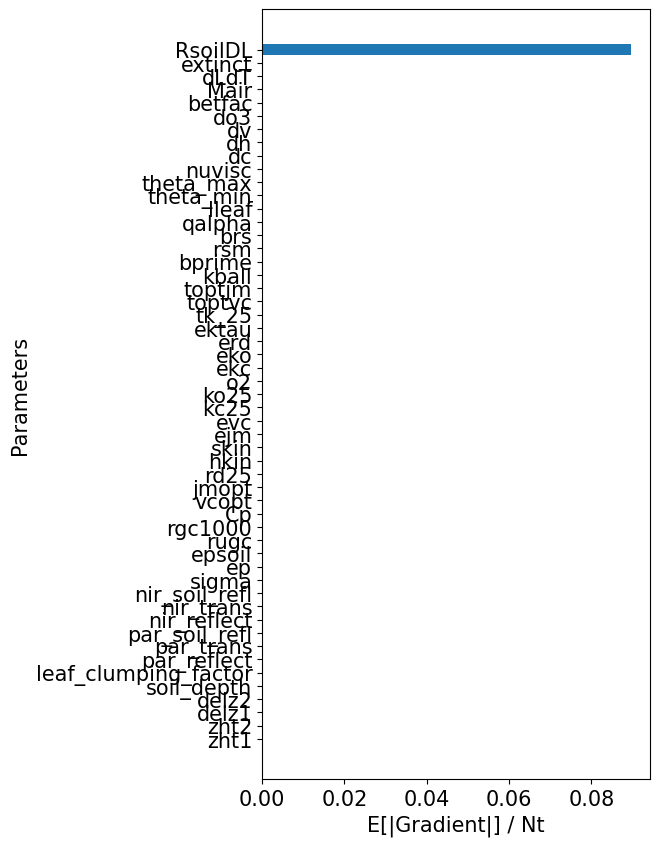

In [26]:
# plot_para_sensitivity_ranking(gradients, category="photosyn")
plot_para_sensitivity_ranking(gradients, category=None)

In [40]:
# gm = jtu.tree_map(lambda x:x.mean(), gradients)
# a, b = jtu.tree_flatten(gm)

In [75]:
# bb = b.node_data()[1]
# names = bb.dynamic_field_names

# Comparison with the observations

<Axes: xlabel='Rnet, measured', ylabel='H+LE+Gsoil, measured'>

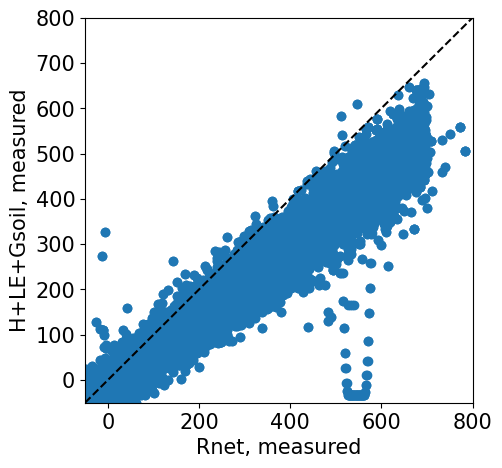

In [21]:
plot_obs_energy_closure(obs)

<Axes: title={'center': 'Rnet (L2: 1718.292)'}, xlabel='Measured', ylabel='Simulated'>

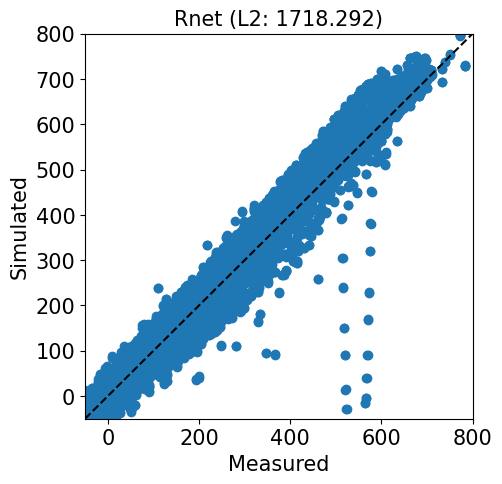

In [22]:
plot_obs_1to1(obs.rnet, can.rnet, lim=[-50, 800], varn="Rnet")

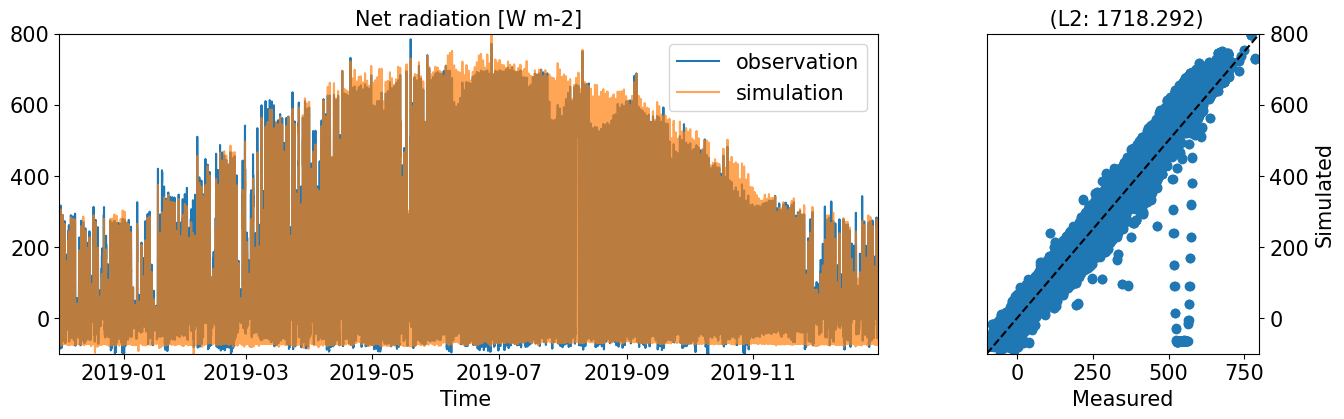

In [23]:
plot_timeseries_obs_1to1(
    obs.rnet,
    can.rnet,
    lim=[-100, 800],
    met=met,
    varn="Net radiation [W m-2]",
);

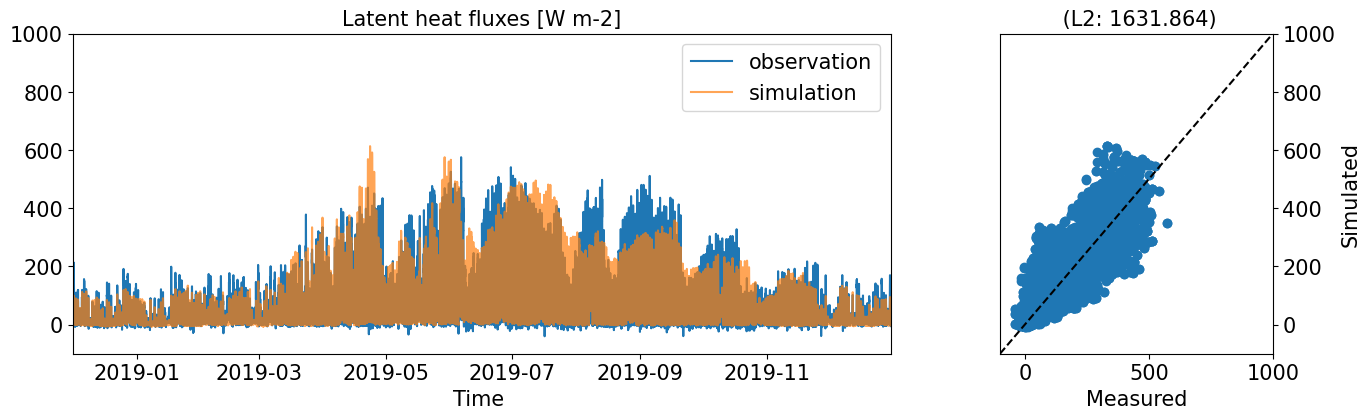

In [24]:
plot_timeseries_obs_1to1(
    obs.LE,
    can.LE,
    lim=[-100, 1000],
    met=met,
    varn="Latent heat fluxes [W m-2]",
);

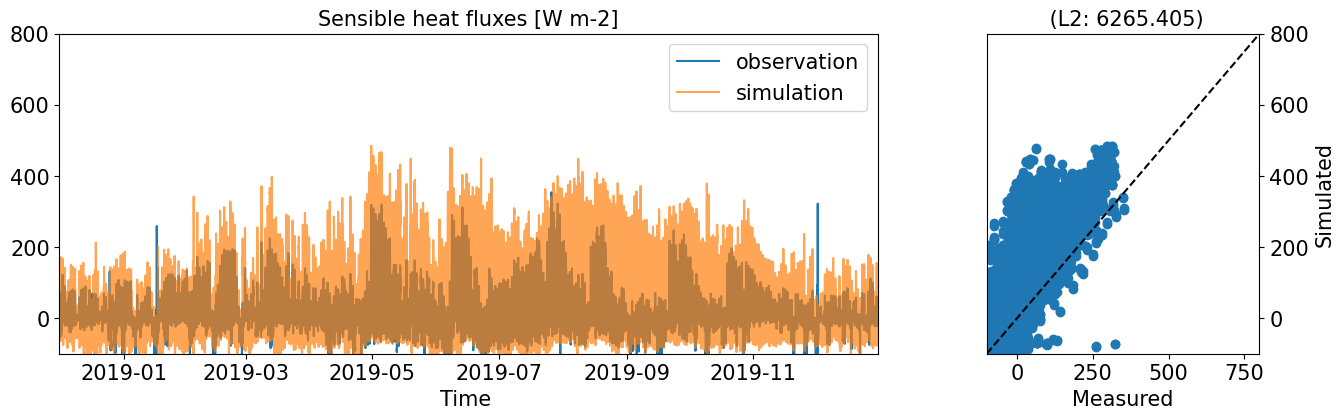

In [25]:
plot_timeseries_obs_1to1(
    obs.H,
    can.H,
    lim=[-100, 800],
    met=met,
    varn="Sensible heat fluxes [W m-2]",
);

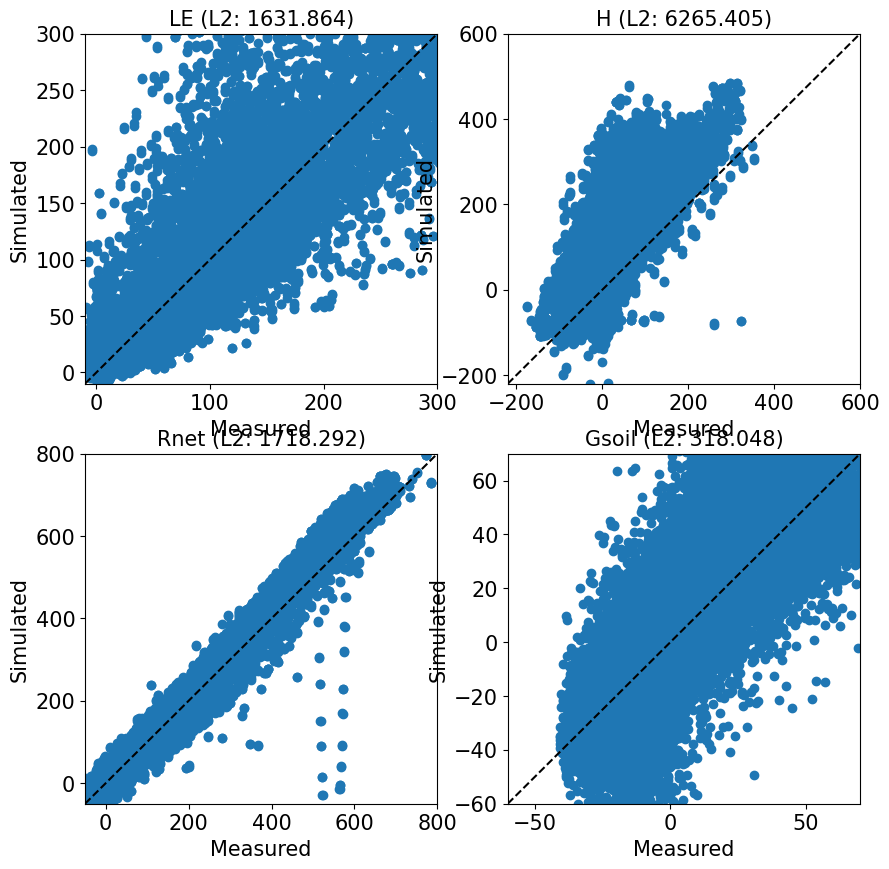

In [26]:
plot_obs_comparison(obs, can);

# Perform the parameter estimation

In [27]:
# Filter the parameters to be estimated
filter_model_spec = jtu.tree_map(lambda _: False, canoak_eqx_ift)
filter_model_spec = eqx.tree_at(
    lambda t: [layer.weight for layer in t.para.RsoilDL.layers],
    filter_model_spec,
    replace=[True for layer in filter_model_spec.para.RsoilDL.layers],
)
filter_model_spec = eqx.tree_at(
    lambda t: [layer.bias for layer in t.para.RsoilDL.layers],
    filter_model_spec,
    replace=[True for layer in filter_model_spec.para.RsoilDL.layers],
)

In [28]:
# jax.clear_caches()
# nsteps = 100  # number of epoches
nsteps = 40  # number of epoches

args = [update_soilresp, get_soilresp]
batched_y = batched_obs.Rsoil
optim = optax.adam(learning_rate=0.01)  # Adam optimizer
canoak_eqx_new, loss_set = perform_optimization_batch(
    canoak_eqx_ift.get_fixed_point_states,
    filter_model_spec.get_fixed_point_states,
    optim,
    batched_y,
    batched_met,
    nsteps,
    *args
)
canoak_eqx_new = canoak_eqx_new.__self__

Argument model is triggering a compile.
Argument filter_model_spec is triggering a compile.
Argument batched_y is triggering a compile.
Argument opt_state is triggering a compile.
Argument batched_met is triggering a compile.
Compiling make_step ...
The loss of step 0: 3.395331030798726
Argument opt_state is triggering a compile.
Compiling make_step ...
The loss of step 1: 2.926907469404656
The loss of step 2: 2.4568314703729617
The loss of step 3: 2.000745216582564
The loss of step 4: 1.5773249914480296
The loss of step 5: 1.2074841681415767
The loss of step 6: 0.9125122545481428
The loss of step 7: 0.7106365547541013
The loss of step 8: 0.61162793783869
The loss of step 9: 0.6100940256156822
The loss of step 10: 0.6809579716757955
The loss of step 11: 0.7836963640249566
The loss of step 12: 0.8772580796925529
The loss of step 13: 0.9348868785787875
The loss of step 14: 0.9479227944771934
The loss of step 15: 0.9209680589581785
The loss of step 16: 0.8655597598754562
The loss of step 

In [27]:
# # Keep training ...
# canoak_eqx_new, loss_set2 = perform_optimization_batch(
#     canoak_eqx_new.get_soil_resp,
#     filter_model_spec.get_soil_resp,
#     optim,
#     batched_y,
#     batched_met,
#     nsteps,
#     *args
# )
# loss_set = loss_set + loss_set2
# canoak_eqx_new = canoak_eqx_new.__self__

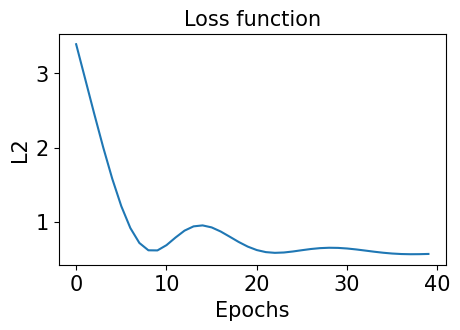

In [28]:
# Plot the loss function
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(loss_set)
ax.set(xlabel="Epochs", ylabel="L2", title="Loss function", yscale="linear");

In [29]:
# visualize_tree_diff(canoak_eqx.para, canoak_eqx_new.para)
canoak_eqx_new.para.RsoilDL.layers[0].weight

Array([[-0.38289492, -0.28949532],
       [ 0.49169327,  0.06953846],
       [ 0.62993494,  0.13662647],
       [ 0.71191052, -0.46923019],
       [ 0.48367772,  0.37142037],
       [ 0.53511705,  0.19192835]], dtype=float64)

## Rerun the model using the estimated parameters


In [30]:
states, drivers = canoak_eqx_new(met)
_, prof_new, ir_new, qin_new, sun_new, shade_new, soil_new, veg_new, can_new = states
quantum_new, nir_new, rnet_new, sun_ang_new, leaf_ang_new, lai_new = drivers
# met, prof, ir, qin, sun, shade, soil, veg, can = run_canoak_in_batch(batched_met, canoak_eqx_ift)

In [31]:
# (
#     _,
#     prof_new,
#     can_new,
#     veg_new,
#     shade_new,
#     sun_new,
#     qin_new,
#     rnet_new,
#     sun_ang_new,
#     ir_new,
#     nir_new,
#     quantum_new,
#     lai_new,
#     leaf_ang_new,
#     soil_new,
# ) = run_canoak_in_batch(batched_met, canoak_eqx_new)

In [18]:
# le_new = run_canoak_in_batch_any(batched_met, canoak_eqx_new.get_can_le)

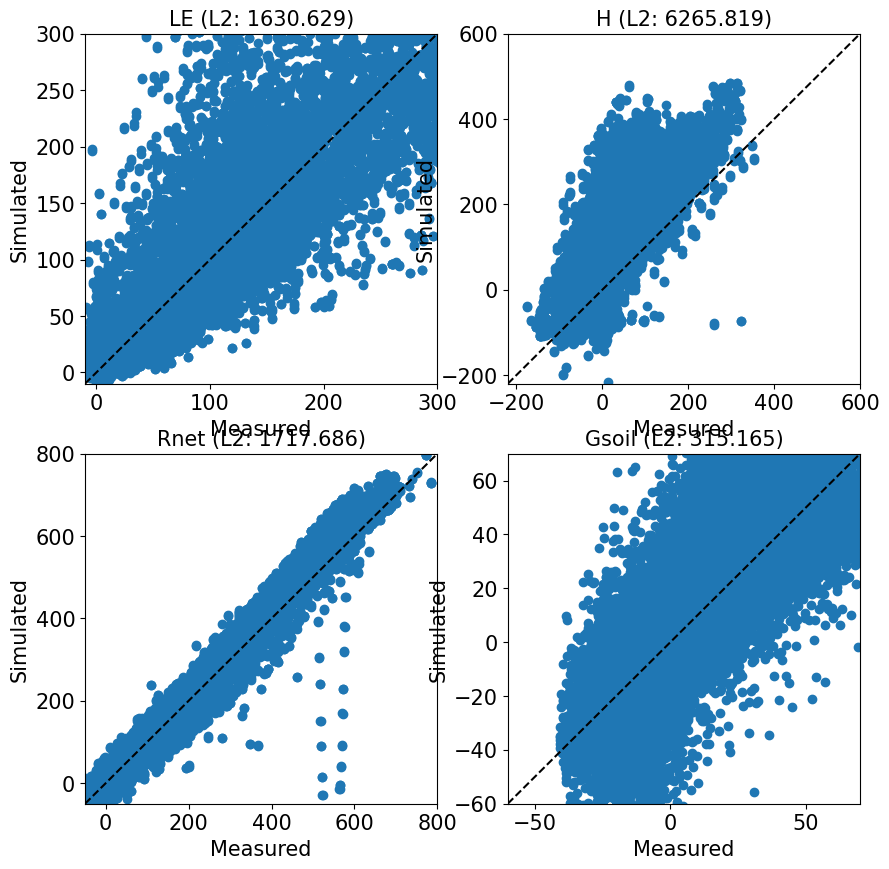

In [32]:
plot_obs_comparison(obs, can_new);

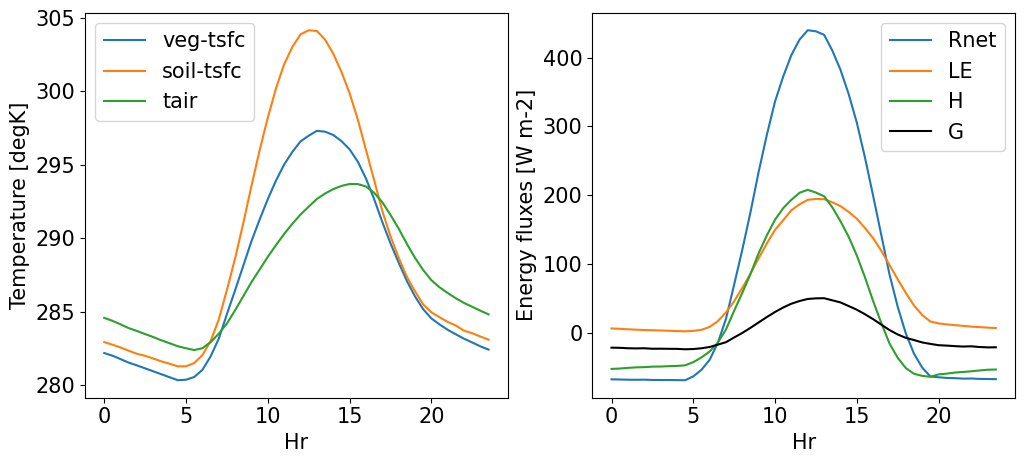

In [34]:
# Daily average
plot_daily(met, soil_new, veg_new, para);

In [21]:
(soil.sfc_temperature - 273.15 - para.var_mean.Tsoil) / para.var_std.Tsoil

Array([-1.47627558, -1.49549616, -1.53991844, ..., -2.28970496,
       -2.32719641, -2.29563896], dtype=float64)

In [22]:
# from jax_canoak.physics.carbon_fluxes import soil_respiration_dnn
# soil_respiration_dnn(soil_new.sfc_temperature, met.soilmoisture, canoak_eqx_new.para)

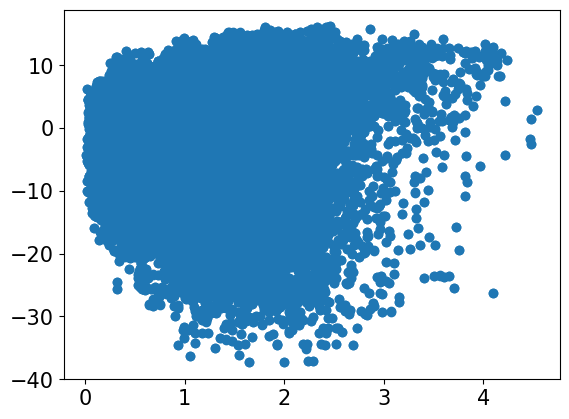

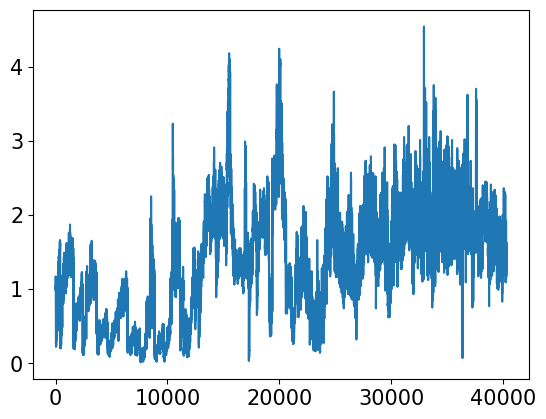

In [48]:
plt.figure(0)
# plt.scatter(obs.Rsoil, soil.T_soil[:,-1]-soil.T_soil[:,0])
plt.scatter(
    obs.Rsoil,
)
plt.figure(1)
# plt.plot(soil_new.resp)
plt.plot(obs.Rsoil)

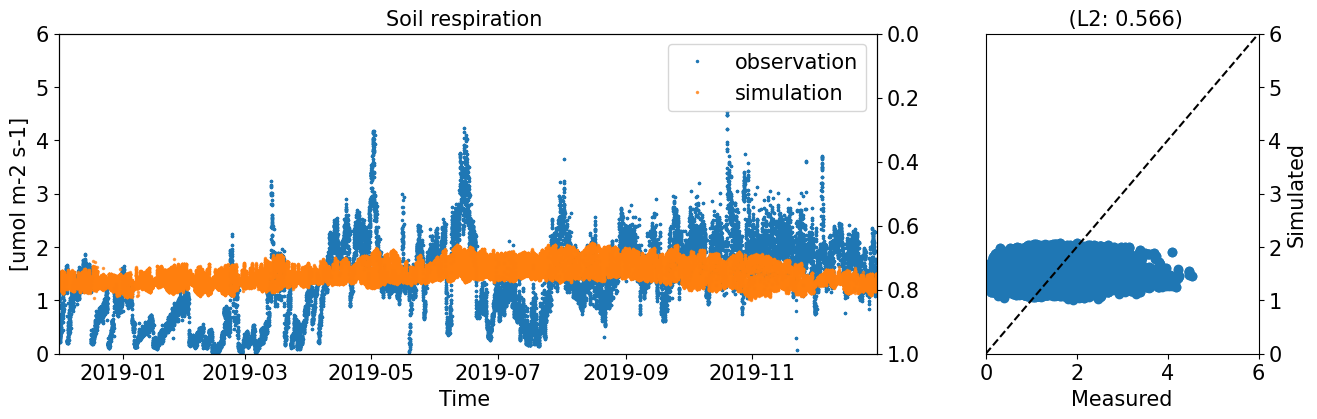

In [33]:
timesteps = get_time(met)

fig, ax1, ax2 = plot_timeseries_obs_1to1(
    obs.Rsoil,
    soil_new.resp,
    lim=[0, 6],
    met=met,
    varn="Soil respiration ",
    linestyle=".",
)
ax1.set(ylabel="[umol m-2 s-1]")
ax12 = ax1.twinx()
ax12.invert_yaxis()
# ax12.plot(timesteps, met.soilmoisture, "k")
# ax12.set(ylim=[10, 0], ylabel="Rainfall [mm]")
# ax12.plot(timesteps, obs.P, "k")
# ax12.set(ylim=[10, 0], ylabel="Rainfall [mm]")

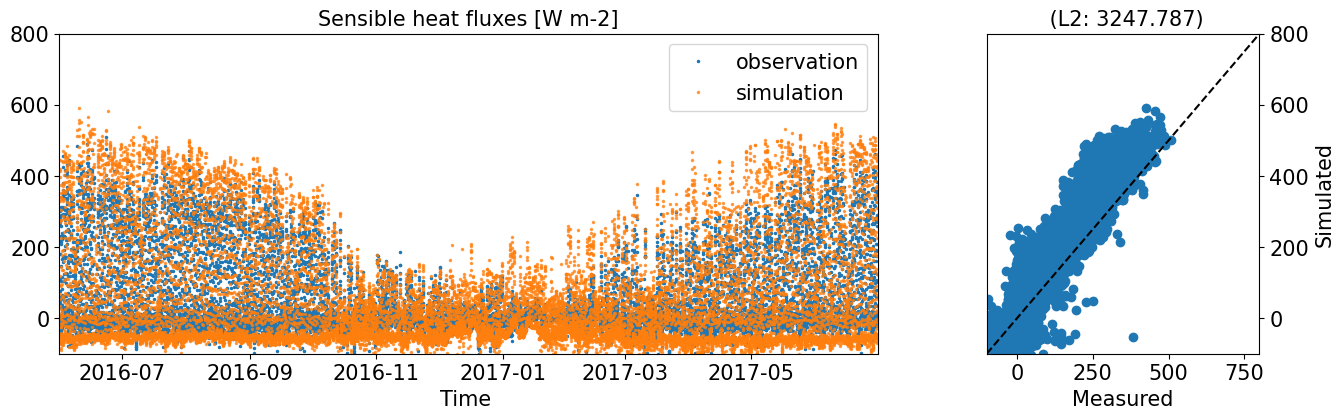

In [64]:
plot_timeseries_obs_1to1(
    obs.H,
    can_new.H,
    lim=[-100, 800],
    met=met,
    varn="Sensible heat fluxes [W m-2]",
    linestyle=".",
);

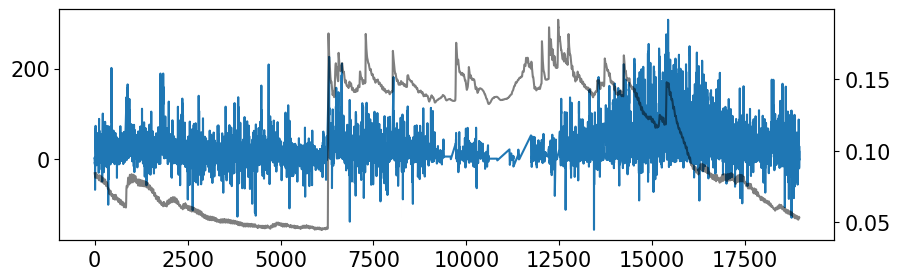

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
# ax.plot(can_new.LE)
ax.plot(obs.LE)
ax2 = ax.twinx()
# ax2.plot(lai.lai, 'black')
# ax2.plot(qin_new.sun_abs.sum(axis=1), 'black', alpha=0.5)
ax2.plot(met.soilmoisture, "black", alpha=0.5)

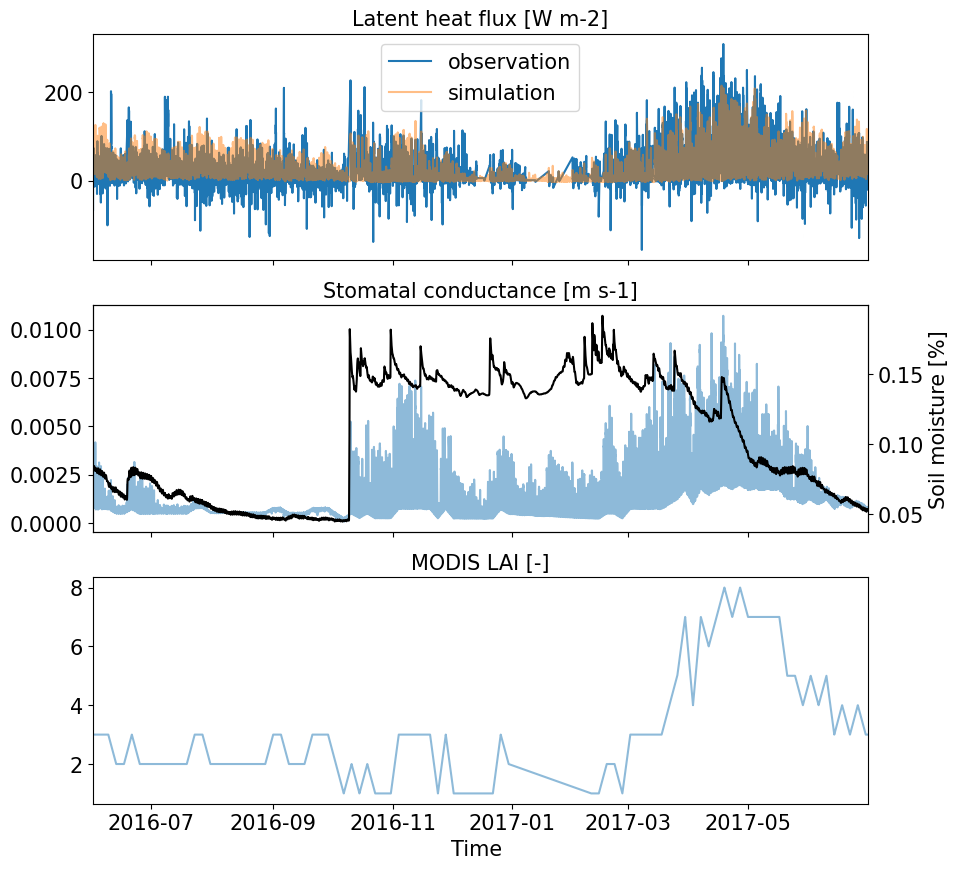

In [35]:
plot_le_gs_lai(can_new.LE, obs.LE, veg_new.gs, lai.lai, met=met)
# plot_le_gs_lai(can_new.LE / lai.lai, obs.LE / lai.lai, veg_new.gs, lai.lai, met=met)
# plot_le_gs_lai(shade_new.LE.mean(axis=1), obs.LE, veg_new.gs, lai.lai, met=met)
# plot_le_gs_lai(soil.evap, obs.LE, veg_new.gs, lai.lai, met=met)

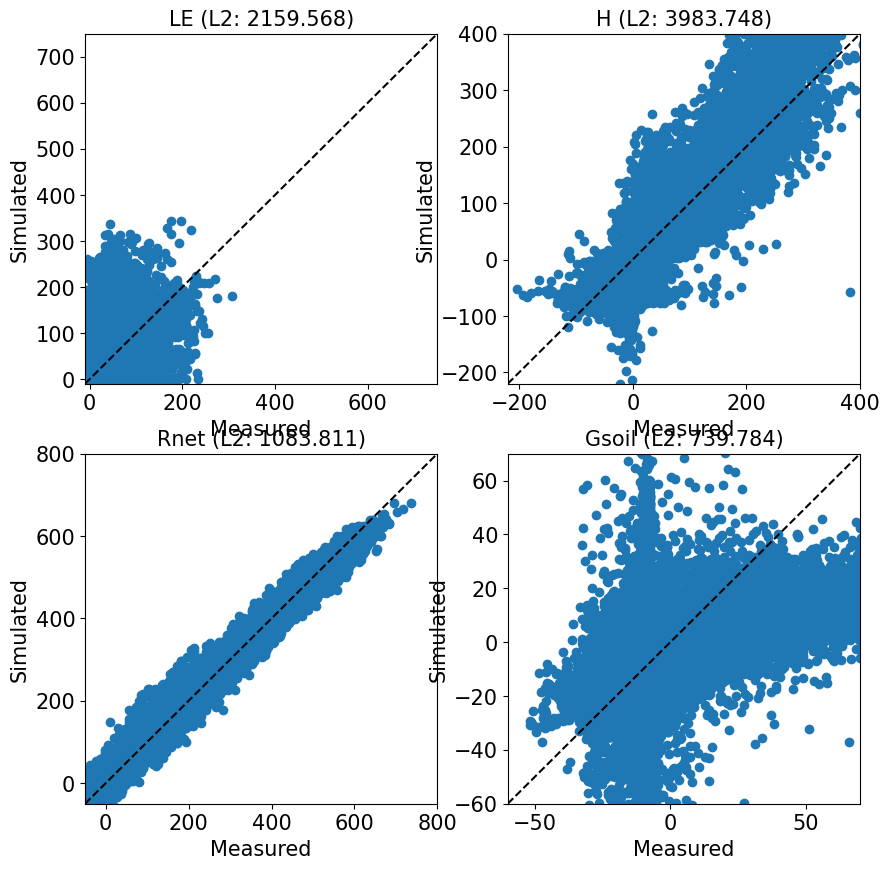

In [31]:
# Try again with another set of parameters
canoak_eqx_new2 = eqx.tree_at(lambda t: t.para.bprime, canoak_eqx_new, 0.005)
(
    _,
    prof_new,
    can_new,
    veg_new,
    shade_new,
    sun_new,
    qin_new,
    rnet_new,
    sun_ang_new,
    ir_new,
    nir_new,
    quantum_new,
    lai_new,
    leaf_ang_new,
    soil_new,
) = run_canoak_in_batch(batched_met, canoak_eqx_new2)
plot_obs_comparison(obs, can_new);

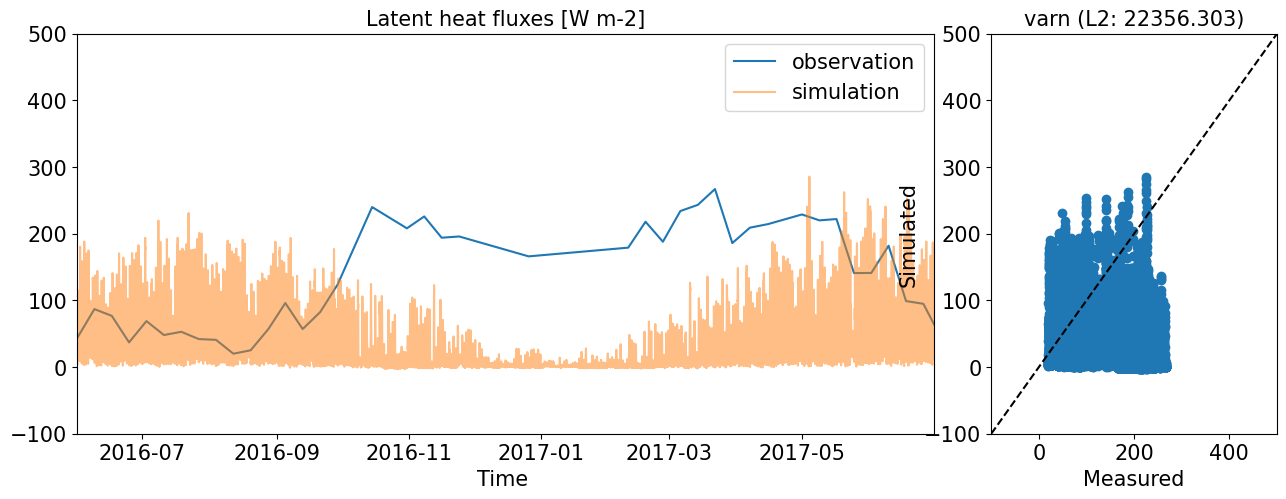

In [76]:
plot_timeseries_obs_1to1(
    obs.LE,
    can_new.LE,
    lim=[-100, 500],
    met=met,
    varn="Latent heat fluxes [W m-2]",
);

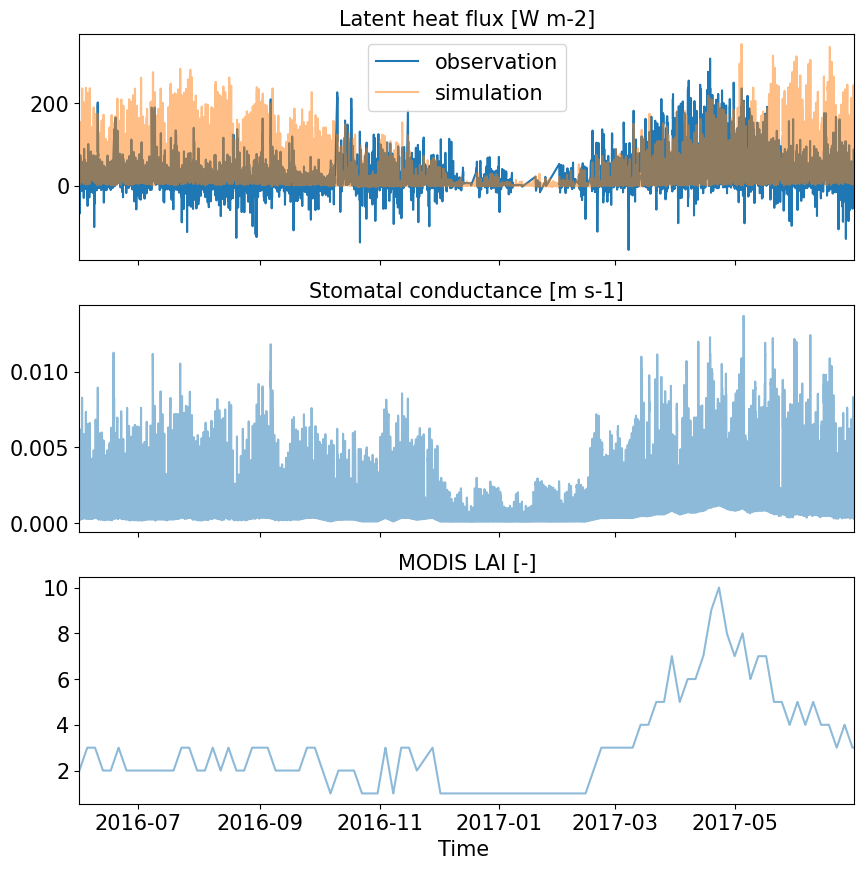

In [33]:
plot_le_gs_lai(can_new.LE, obs.LE, veg_new.gs, lai.lai, met=met)